In practice, very few people train an entire Convolutional Network from scratch (with random initialization), because it is relatively rare to have a dataset of sufficient size. Instead, it is common to pretrain a ConvNet on a very large dataset (e.g. ImageNet, which contains 1.2 million images with 1000 categories), and then use the ConvNet either as an initialization or a fixed feature extractor for the task of interest.

In [ ]:
from __future__ import print_function, division

import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
from torch.autograd import Variable
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import os
import copy
from torch.utils.data import Dataset, DataLoader
import pandas as pd;

plt.ion()   # interactive mode

In [0]:
# # http://pytorch.org/
# from os import path
# from wheel.pep425tags import get_abbr_impl, get_impl_ver, get_abi_tag
# platform = '{}{}-{}'.format(get_abbr_impl(), get_impl_ver(), get_abi_tag())

# accelerator = 'cu80' if path.exists('/opt/bin/nvidia-smi') else 'cpu'

# !pip install -q http://download.pytorch.org/whl/{accelerator}/torch-0.4.0-{platform}-linux_x86_64.whl torchvision
# print(torch.__version__)

In [0]:
# declare the essential hyperparameters
num_epochs = 5;
batch_size = 100;
learning_rate = 0.001;
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [0]:
# Data augmentation and normalization for training
# Just normalization for validation
data_transforms = {
    'train': transforms.Compose([
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Lambda(lambda x: x.expand(3,224, -1)),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'test': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Lambda(lambda x: x.expand(3,224, -1)),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

In [0]:
# load fashionMNIST dataset from torch
fashion_mnist_train_data = torchvision.datasets.FashionMNIST('../datasets/', train=True, transform=data_transforms['train'], target_transform=None, download=True)
fashion_mnist_test_data = torchvision.datasets.FashionMNIST('../datasets/', train=False, transform=data_transforms['test'], target_transform=None, download=True)

In [0]:
# define the data loaders using the DataLoader module
train_loader = torch.utils.data.DataLoader(dataset=fashion_mnist_train_data,
                                           batch_size=batch_size,
                                           shuffle=True);
test_loader = torch.utils.data.DataLoader(dataset=fashion_mnist_test_data,
                                          batch_size=batch_size,
                                          shuffle=True);

In [7]:
# train data size for first batch
image, labels = next(iter(train_loader))
image.shape

torch.Size([100, 3, 224, 224])

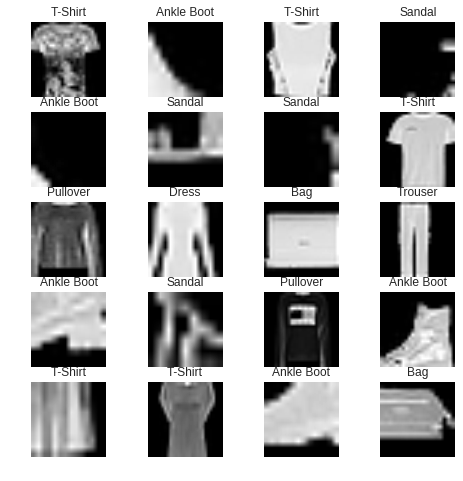

In [16]:
# using the data reader to visualize some images and see the dataset
labels_map = {0 : 'T-Shirt', 1 : 'Trouser', 2 : 'Pullover', 3 : 'Dress', 4 : 'Coat', 5 : 'Sandal', 6 : 'Shirt',
              7 : 'Sneaker', 8 : 'Bag', 9 : 'Ankle Boot'};
fig = plt.figure(figsize=(8,8));
columns = 4;
rows = 5;
for i in range(1, columns*rows +1):
    img_xy = np.random.randint(len(fashion_mnist_train_data));
    img = fashion_mnist_train_data[img_xy][0][0,:,:]
    fig.add_subplot(rows, columns, i)
    plt.title(labels_map[int(fashion_mnist_train_data[img_xy][1])])
    plt.axis('off')
    plt.imshow(img, cmap='gray')
plt.show()

## 1. Finetuning the convnet

Instead of random initializaion, we initialize the network with a pretrained network, like the one that is trained on imagenet 1000 dataset. Rest of the training looks as usual.

Load a pretrained model and reset final fully connected layer.

In [0]:
#instance of the ResNet
model_ft = torchvision.models.resnet18(pretrained=True)
num_ftrs = model_ft.fc.in_features
model_ft.fc = nn.Linear(num_ftrs, 10)
model_ft.to(device)

# loss function and optimizer
criterion = nn.CrossEntropyLoss()

# Observe that all parameters are being optimized
optimizer = optim.SGD(model_ft.parameters(), lr=learning_rate, momentum=0.9)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)

In [52]:
# Training the model
losses = [];
for epoch in range(num_epochs):
    model_ft.train()
    for i, (images, labels) in enumerate(train_loader):
        images = Variable(images.float())
        labels = Variable(labels)
        images = images.to(device)
        labels = labels.to(device)

        # Forward + Backward + Optimize
        optimizer.zero_grad()
        outputs = model_ft(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        
        losses.append(loss.data[0]);
        
        if (i+1) % 100 == 0:
            print ('Epoch : %d/%d, Iter : %d/%d,  Loss: %.4f' 
                   %(epoch+1, num_epochs, i+1, len(fashion_mnist_train_data)//batch_size, loss.data[0]))

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:17: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:21: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Epoch : 1/5, Iter : 100/600,  Loss: 0.8254
Epoch : 1/5, Iter : 200/600,  Loss: 0.6968
Epoch : 1/5, Iter : 300/600,  Loss: 0.7097
Epoch : 1/5, Iter : 400/600,  Loss: 0.6708
Epoch : 1/5, Iter : 500/600,  Loss: 0.6052
Epoch : 1/5, Iter : 600/600,  Loss: 0.5997
Epoch : 2/5, Iter : 100/600,  Loss: 0.6102
Epoch : 2/5, Iter : 200/600,  Loss: 0.4958
Epoch : 2/5, Iter : 300/600,  Loss: 0.5078
Epoch : 2/5, Iter : 400/600,  Loss: 0.6557
Epoch : 2/5, Iter : 500/600,  Loss: 0.5314
Epoch : 2/5, Iter : 600/600,  Loss: 0.6188
Epoch : 3/5, Iter : 100/600,  Loss: 0.4699
Epoch : 3/5, Iter : 200/600,  Loss: 0.4318
Epoch : 3/5, Iter : 300/600,  Loss: 0.4806
Epoch : 3/5, Iter : 400/600,  Loss: 0.5467
Epoch : 3/5, Iter : 500/600,  Loss: 0.5418
Epoch : 3/5, Iter : 600/600,  Loss: 0.5802
Epoch : 4/5, Iter : 100/600,  Loss: 0.4238
Epoch : 4/5, Iter : 200/600,  Loss: 0.5199
Epoch : 4/5, Iter : 300/600,  Loss: 0.3758
Epoch : 4/5, Iter : 400/600,  Loss: 0.4423
Epoch : 4/5, Iter : 500/600,  Loss: 0.5826
Epoch : 4/5

In [54]:
# Evaluating the model
model_ft.eval()
correct = 0
total = 0
for i, (images, labels) in enumerate(test_loader):
    images = Variable(images.float())
    images = images.to(device)
    labels = labels.to(device)
    outputs = model_ft(images)
    _, predicted = torch.max(outputs.data, 1)
    total += labels.size(0)
    correct += (predicted == labels).sum()
print('Test Accuracy of the model on the 10000 test images: %.4f %%' % (100 * correct / total))

Test Accuracy of the model on the 10000 test images: 91.0000 %


/usr/local/lib/python3.6/dist-packages/matplotlib/font_manager.py:1320: UserWarning: findfont: Font family ['xkcd', 'Humor Sans', 'Comic Sans MS'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


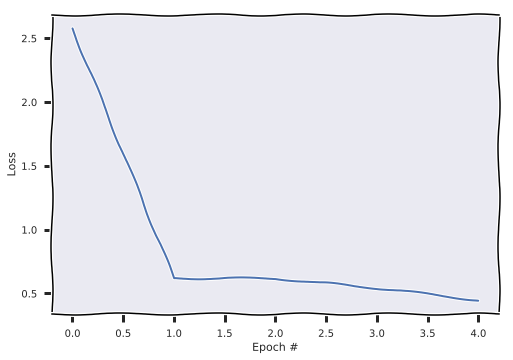

In [53]:
# Visualizing the loss
losses_in_epochs = losses[0::600]
plt.xkcd();
plt.xlabel('Epoch #');
plt.ylabel('Loss');
plt.plot(losses_in_epochs);
plt.show();

## 2. ConvNet as fixed feature extractor

Here, we will freeze the weights for all of the network except that of the final fully connected layer. This last fully connected layer is replaced with a new one with random weights and only this layer is trained.

We need to set `requires_grad == False` to freeze the parameters so that the `gradients` are not computed in `backward()`.

In [9]:
model_conv = torchvision.models.resnet18(pretrained=True)
for param in model_conv.parameters():
    param.requires_grad = False

# Parameters of newly constructed modules have requires_grad=True by default
num_ftrs = model_conv.fc.in_features
model_conv.fc = nn.Linear(num_ftrs, 10)

model_conv = model_conv.to(device)

criterion = nn.CrossEntropyLoss()

# Observe that only parameters of final layer are being optimized as
# opoosed to before.
optimizer_conv = optim.SGD(model_conv.fc.parameters(), lr=0.001, momentum=0.9)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_conv, step_size=7, gamma=0.1)

model_conv.to(device)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace)
      (conv2): Co

### Training the model

On CPU this will take about half the time compared to previous scenario. This is expected as gradients don’t need to be computed for most of the network. However, forward does need to be computed.

In [10]:
# model training
losses = [];
for epoch in range(num_epochs):
    exp_lr_scheduler.step()
    model_conv.train()
     
    for i, (images, labels) in enumerate(train_loader):
        images = Variable(images.float())
        labels = Variable(labels)
        images = images.to(device)
        labels = labels.to(device)

        # Forward + Backward + Optimize
        optimizer_conv.zero_grad()
        outputs = model_conv(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer_conv.step()
        
        losses.append(loss.data[0]);
        
        if (i+1) % 100 == 0:
            print ('Epoch : %d/%d, Iter : %d/%d,  Loss: %.4f' 
                   %(epoch+1, num_epochs, i+1, len(fashion_mnist_train_data)//batch_size, loss.data[0]))

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:19: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:23: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Epoch : 1/5, Iter : 100/600,  Loss: 1.6069
Epoch : 1/5, Iter : 200/600,  Loss: 1.3052
Epoch : 1/5, Iter : 300/600,  Loss: 1.2710
Epoch : 1/5, Iter : 400/600,  Loss: 1.1019
Epoch : 1/5, Iter : 500/600,  Loss: 1.0891
Epoch : 1/5, Iter : 600/600,  Loss: 1.1198
Epoch : 2/5, Iter : 100/600,  Loss: 0.9372
Epoch : 2/5, Iter : 200/600,  Loss: 1.2533
Epoch : 2/5, Iter : 300/600,  Loss: 1.1499
Epoch : 2/5, Iter : 400/600,  Loss: 1.0543
Epoch : 2/5, Iter : 500/600,  Loss: 1.0902
Epoch : 2/5, Iter : 600/600,  Loss: 1.0441
Epoch : 3/5, Iter : 100/600,  Loss: 1.0313
Epoch : 3/5, Iter : 200/600,  Loss: 0.9721
Epoch : 3/5, Iter : 300/600,  Loss: 0.9219
Epoch : 3/5, Iter : 400/600,  Loss: 0.8572
Epoch : 3/5, Iter : 500/600,  Loss: 0.8774
Epoch : 3/5, Iter : 600/600,  Loss: 0.8068
Epoch : 4/5, Iter : 100/600,  Loss: 0.8867
Epoch : 4/5, Iter : 200/600,  Loss: 0.8438
Epoch : 4/5, Iter : 300/600,  Loss: 1.0747
Epoch : 4/5, Iter : 400/600,  Loss: 0.8044
Epoch : 4/5, Iter : 500/600,  Loss: 1.0908
Epoch : 4/5

In [12]:
# Evaluating the model
model_conv.eval()
correct = 0
total = 0
for i, (images, labels) in enumerate(test_loader):
    images = Variable(images.float())
    images = images.to(device)
    labels = labels.to(device)
    outputs = model_conv(images)
    _, predicted = torch.max(outputs.data, 1)
    total += labels.size(0)
    correct += (predicted == labels).sum()
print('Test Accuracy of the model on the 10000 test images: %.4f %%' % (100 * correct / total))

Test Accuracy of the model on the 10000 test images: 79.0000 %


/usr/local/lib/python3.6/dist-packages/matplotlib/font_manager.py:1320: UserWarning: findfont: Font family ['xkcd', 'Humor Sans', 'Comic Sans MS'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


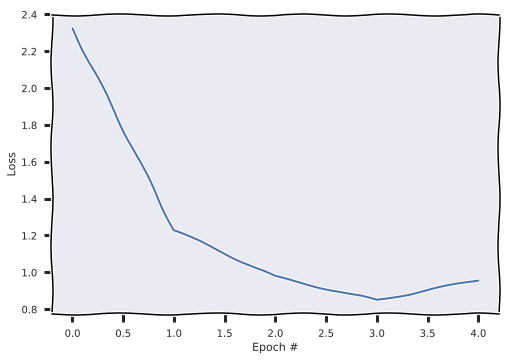

In [11]:
# Visualizing the loss
losses_in_epochs = losses[0::600]
plt.xkcd();
plt.xlabel('Epoch #');
plt.ylabel('Loss');
plt.plot(losses_in_epochs);
plt.show();